In [30]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
%matplotlib inline
import random
import importlib
import Scripts.autoencoder as ae
import Scripts.wake_processing as wp
from collections import OrderedDict
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import gc
from tqdm import tqdm
from collections import Counter

In [3]:
import Scripts.mnist_cnn as cnn


In [4]:
importlib.reload(cnn)

<module 'Scripts.mnist_cnn' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\mnist_cnn.py'>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training Data

In [6]:
real_wakes = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes.npy")
not_wakes = np.load("Data\\Wake data\\negative_day_samples.npy")

In [7]:
real_wakes = real_wakes[:,:,:-1,:]
not_wakes = not_wakes[:,:,:-1,:]

In [8]:
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=4)
train_gen, test_gen = train_test_split(generated_wakes, test_size=0.08, random_state=4)
train_neg, test_neg = train_test_split(not_wakes, test_size = 0.06, random_state = 4)

In [9]:
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [10]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [11]:
test_dataset.tensors[0].shape

torch.Size([118, 4, 28, 60])

In [12]:
test_dataset.tensors[1].shape

torch.Size([118, 2])

## Training

In [13]:
def train_cnn(model, train_data, test_data, num_epochs=5, batch_size=5, learning_rate=1e-3):
    model = model.to(device)
    torch.manual_seed(0)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_pred_label = 1 - torch.argmax(pred, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(loss.item())
            
        val_pred = model(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion(val_pred, y_val).item()
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_acc = accuracy_score(val_true_label, val_pred_label)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                               val_loss, train_acc, val_acc))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
    return train_losses, val_losses, train_accs, val_accs

## Test CNN

In [14]:
cnn_model = None
cnn_model = cnn.MNISTCNN()
train_losses, val_losses, train_accs, val_accs = train_cnn(cnn_model, train_dataset, test_dataset, num_epochs = 80, learning_rate=1e-4)

Epoch:1, Loss:0.6333, Val Loss:0.7587, Train Acc:0.679710, Val Acc:0.5085
Epoch:2, Loss:0.6226, Val Loss:0.7771, Train Acc:0.680435, Val Acc:0.5085
Epoch:3, Loss:0.6020, Val Loss:0.7326, Train Acc:0.679710, Val Acc:0.5085
Epoch:4, Loss:0.5129, Val Loss:0.6542, Train Acc:0.680435, Val Acc:0.5085
Epoch:5, Loss:0.4669, Val Loss:0.9115, Train Acc:0.774638, Val Acc:0.6017
Epoch:6, Loss:0.4242, Val Loss:0.7652, Train Acc:0.881159, Val Acc:0.7119
Epoch:7, Loss:0.3603, Val Loss:0.5347, Train Acc:0.895652, Val Acc:0.7627
Epoch:8, Loss:0.3102, Val Loss:0.5706, Train Acc:0.906522, Val Acc:0.7881
Epoch:9, Loss:0.2740, Val Loss:0.6855, Train Acc:0.909420, Val Acc:0.7458
Epoch:10, Loss:0.2537, Val Loss:0.5912, Train Acc:0.916667, Val Acc:0.7712
Epoch:11, Loss:0.2173, Val Loss:0.5659, Train Acc:0.929710, Val Acc:0.7797
Epoch:12, Loss:0.2007, Val Loss:0.4614, Train Acc:0.936232, Val Acc:0.8220
Epoch:13, Loss:0.1880, Val Loss:0.6090, Train Acc:0.936957, Val Acc:0.7966
Epoch:14, Loss:0.1700, Val Loss:0.

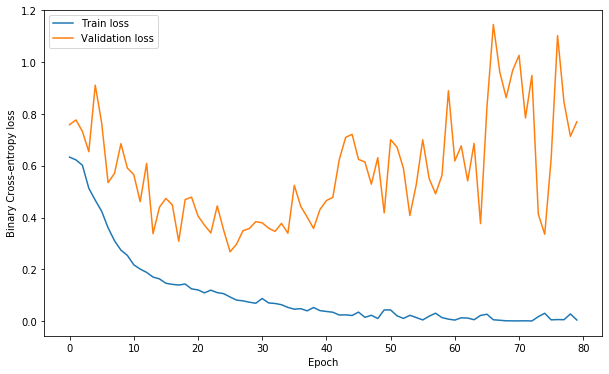

In [15]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Validation loss')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-entropy loss')
plt.show()

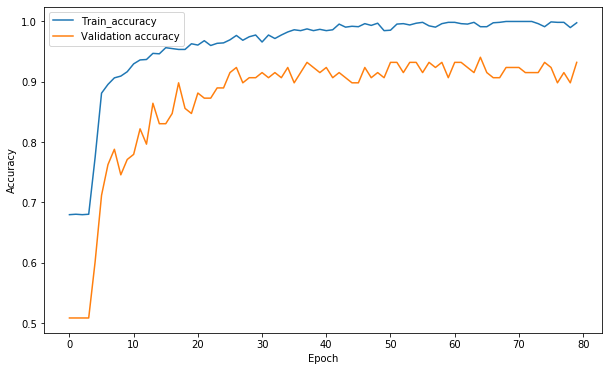

In [16]:
plt.figure(figsize=(10,6))
plt.plot(train_accs, label = 'Train_accuracy')
plt.plot(val_accs, label = 'Validation accuracy')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Passing Full Training Dataset

In [17]:
data_series = wp.get_files()
cutoff = np.where(data_series[0,-2]<wp.date_to_stamp([9, 22, 0, 0]))[0][-1]
train_series = data_series[:,:,:cutoff]
test_series = data_series[:,:,cutoff:]

In [21]:
predictions = []
for i in tqdm(range((train_series.shape[2] - 60) // 5)):
    if train_series[0, -1, 5*i] == 1:
        time = train_series[0, -2, 5*i]
        next_frame = torch.from_numpy(train_series[:,:-2,5*i:5*i+60]).float().unsqueeze(0).to(device)
        label = int(torch.argmax(cnn_model(next_frame), dim = 1).cpu().detach())
        predictions.append(np.array([time, label]))     

100%|███████████████████████████████████████████████████████████████████████████| 13824/13824 [00:24<00:00, 575.60it/s]


In [22]:
predictions = np.array(predictions)
predicted_ws = predictions[np.where(predictions[:,1] == 0)][:,0]

In [23]:
wake_start = wp.get_wakes()
new_ws = wake_start
for ws in wake_start:
    if ws not in set(data_series[0,-2,:]):
        if ws-12 in set(data_series[0,-2,:]):
            new_ws = np.append(new_ws, ws-12)

In [24]:
unknown_wakes = predicted_ws
for ws in new_ws:
    unknown_wakes = unknown_wakes[np.where((ws-1800 >= unknown_wakes) | (unknown_wakes  >= ws+1800))]

In [25]:
predicted_wakes = wp.frames_by_timestamps(train_series[:,:-1,:], unknown_wakes)

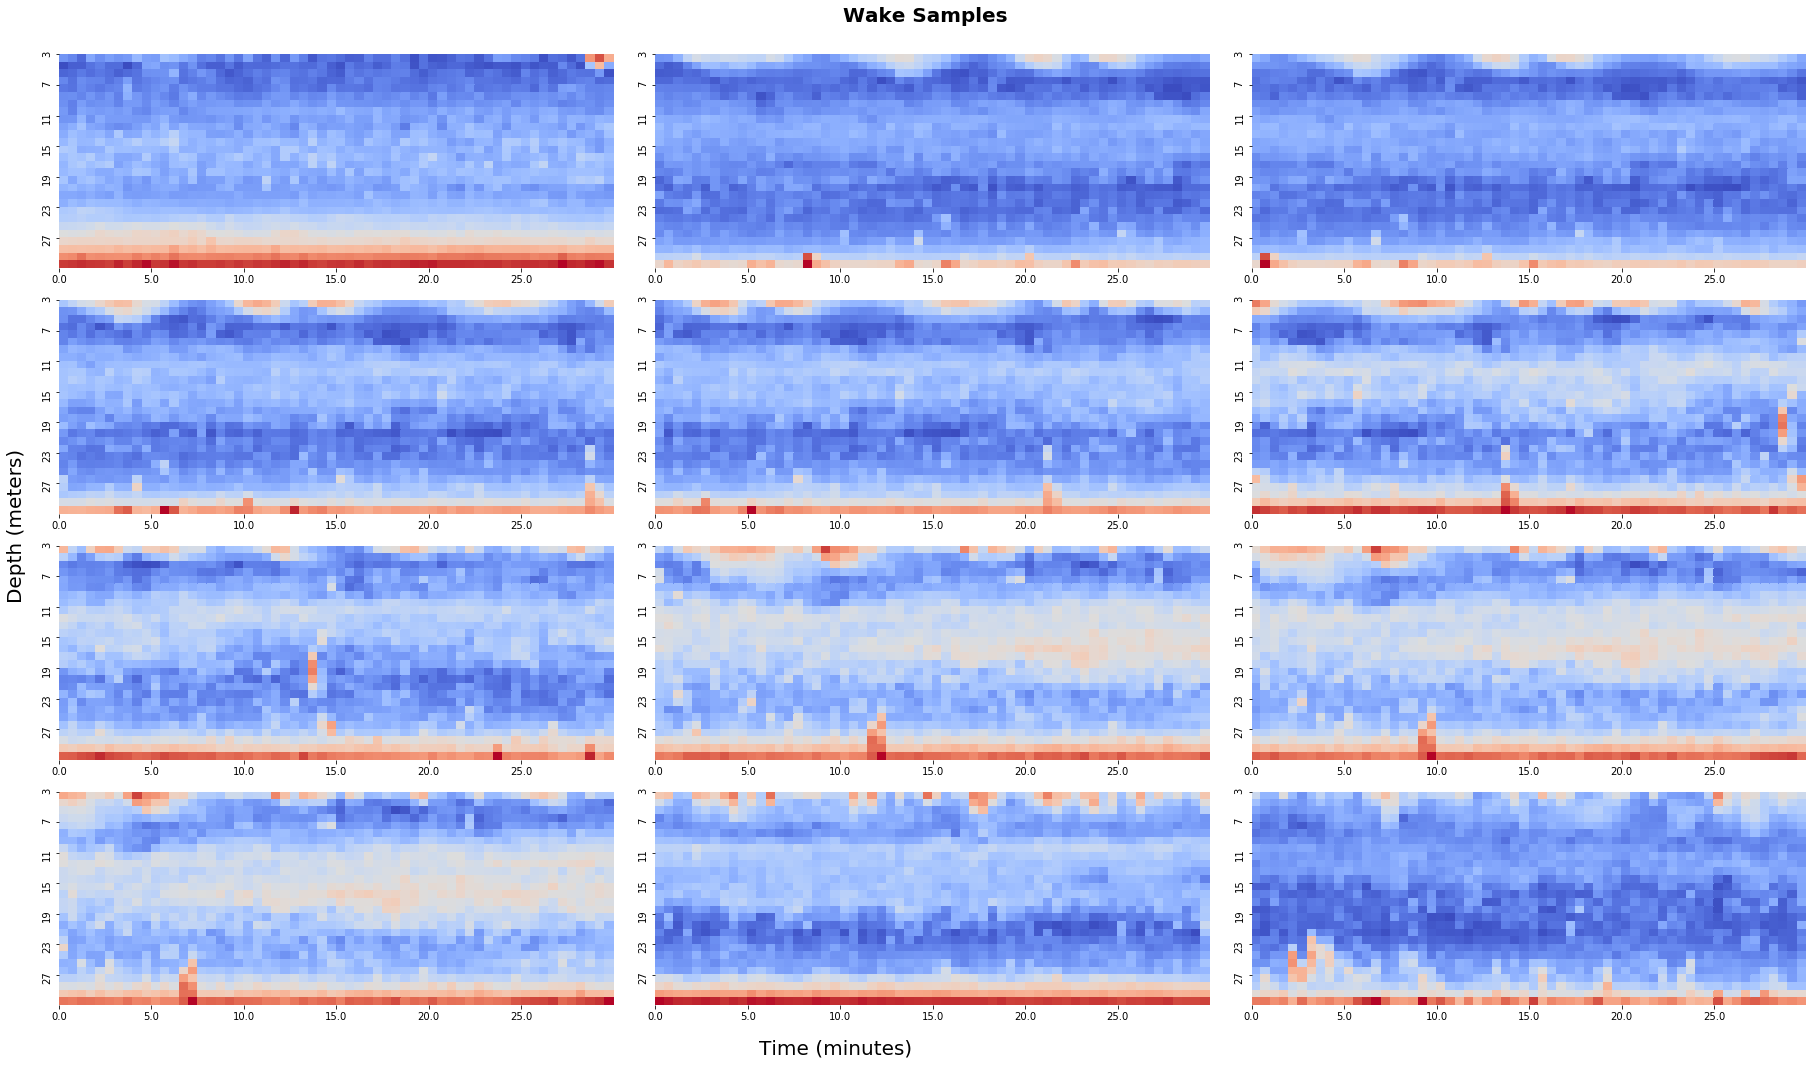

In [26]:
wp.make_12_heatmaps(predicted_wakes[:12, 3, :-1,:])

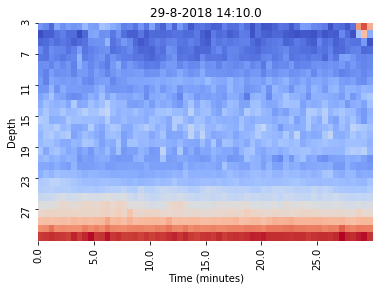

In [27]:
wp.make_heatmap(predicted_wakes[0, 3, :-1,:], predicted_wakes[0, 3,-1,:])

In [28]:
days = []
for uw in unknown_wakes:
    days.append(wp.stamp_to_date(uw)[1])

In [31]:
Counter(days) # Day: false negatives

Counter({29.0: 1,
         31.0: 12,
         3.0: 3,
         6.0: 1,
         7.0: 2,
         8.0: 15,
         9.0: 12,
         10.0: 4,
         11.0: 36,
         12.0: 103,
         13.0: 82,
         14.0: 188,
         15.0: 182,
         16.0: 103,
         17.0: 152,
         18.0: 157,
         19.0: 238,
         20.0: 232,
         21.0: 42})

Periods of noise according to the data description:
-	2018-09-08 07:00 – 2018-09-09 14:00
-	2018-09-11 07:00 - 2018-09-13 00:00  
-	2018-09-16 12:00 - 2018-09-17 10:00  
-	2018-09-18 08:00 - 2018-09-18 19:00  
-	2018-09-19 12:00 - 2018-09-20 17:00
-	2018-09-21 00:00 - 2018-09-23 10:00 
